In [1]:
import os
import sys
import numpy as np
root = "/data/public/renhaoye/morphics/"
pkg = "/data/public/renhaoye/mgs/"
subdirs = [os.path.join(pkg, d) for d in os.listdir(pkg) if os.path.isdir(os.path.join(pkg, d))]
for subdir in subdirs:
    sys.path.append(subdir)
from astropy.io import fits
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from utils.utils import *
%matplotlib inline
def arcsinh_rgb(imgs, bands, scales=None,m = 0.03):
    import numpy as np
    rgbscales =dict(g=(2,6.0), r=(1,3.4), z=(0,2.2))
    if scales is not None:
        rgbscales.update(scales)

    I = 0
    for img,band in zip(imgs, bands):
        plane,scale = rgbscales[band]
        img = np.maximum(0, img * scale + m)
        I = I + img
    I /= len(bands)

    Q = 50
    fI = np.arcsinh(Q * I) / np.sqrt(Q)
    # fI = MTF(I)
    I += (I == 0.) * 1e-9
    H,W = I.shape
    rgb = np.zeros((H,W,3), np.float32)
    for img,band in zip(imgs, bands):
        plane,scale = rgbscales[band]
        rgb[:,:,plane] = (img * scale + m) * fI / I
    rgb = np.clip(rgb, 0, 1)
    return rgb

In [6]:
import pandas as pd
df_c = pd.read_csv(root + "/dataset/gz_decals_volunteers_c.csv", index_col=0).rename(columns=lambda x: x.replace("-", "_")).fillna(0)
"""local files in DECaLS"""
# df_in_decals = load_dir("/data/public/renhaoye/morphics/dataset/in_decals/raw_fits/")
# df_in_decals = load_dir("/data1/public/BGS/bgs_bright_south/")
south_img = load_dir("/data1/public/BGS/bgs_bright_south/")
overlap_south_img = load_dir("/data1/public/BGS/bgs_bright_south_overlap/")
north_img = load_dir("/data1/public/BGS/bgs_bright_north/")
overlap_north_img = load_dir("/data1/public/BGS/bgs_bright_north_overlap/")

df_in_decals = pd.concat([load_dir("/data1/public/BGS/bgs_bright_south/"), load_dir("/data1/public/BGS/bgs_bright_south_overlap/")])
"""local files in BASS+MzLS"""
# df_out_decals = load_dir("/data/public/renhaoye/morphics/dataset/out_decals/raw_fits/")
# df_out_decals = load_dir("/data1/public/BGS/bgs_bright_north/")
df_out_decals = pd.concat([load_dir("/data1/public/BGS/bgs_bright_north/"), load_dir("/data1/public/BGS/bgs_bright_north_overlap/")])
# """main galaxy sample"""
# with fits.open("/data/public/renhaoye/nsa_v1_0_1.fits") as hdul:
#     ra = np.array(hdul[1].data["RA      "])
#     dec = np.array(hdul[1].data["DEC     "])
#     flux = np.array(hdul[1].data["PETRO_FLUX"][:, 4])
#     # 为非正值设定一个小的正数值或直接将其设为NaN
#     flux[flux <= 0] = np.nan
#     petro_mag = -2.5 * np.log10(flux) + 22.5
#     z = np.array(hdul[1].data["Z"])
#     petro_th = np.array(hdul[1].data["PETRO_THETA"])
#     MGS = pd.DataFrame(np.array((ra, dec, petro_mag, z, petro_th)).T, columns=["ra", "dec", "petro_mag", "z", "petro_th"])
# ra = []
# dec = []
# with open("/data/public/renhaoye/morphics/dataset/overlap_north_raw.txt", "r") as r:
#     # 按行读取文件
#     lines = r.readlines()
#     # 对每行的字符串进行提取,保留raw_fits/和.fits中间的字符串
#     for line in lines:
#         if os.path.exists(line.split(" label")[0]):
#             ra.append(float(line.split("raw_fits/")[1].split(".fits")[0].split("_")[0]))
#             dec.append(float(line.split("raw_fits/")[1].split(".fits")[0].split("_")[1]))

In [2]:
"""for flux estimate"""
data = fits.open("/data1/public/BGS/BGS_BRIGHT_SOUTH.fits")
ra = np.array(data[1].data["RA      "])
dec = np.array(data[1].data["DEC     "])
release = np.array(data[1].data["RELEASE "])
brickid = np.array(data[1].data["BRICKID "])
brickname = np.array(data[1].data["BRICKNAME "])
brickobjid = np.array(data[1].data["BRICK_OBJID"])
flux_g = np.array(data[1].data["FLUX_G  "])
flux_r = np.array(data[1].data["FLUX_R  "])
flux_z = np.array(data[1].data["FLUX_Z  "])
bright_id = pd.DataFrame(np.array((ra, dec,release, brickid, brickname, brickobjid, flux_g, flux_r, flux_z)).T, columns=["ra", "dec", "release", "brickid", "brickname", "brickobjid", "flux_g", "flux_r", "flux_z"])
bright_id.head()

,ra,dec,release,brickid,brickname,brickobjid,flux_g,flux_r,flux_z
0,328.7156249444488,27.63432602933804,9010,485467,3288p277,579,18.243229,52.62409,106.959114
1,328.9466755042228,27.64660925663617,9010,485467,3288p277,4861,5.6847825,14.367889,26.101847
2,328.9567463275409,27.646560346950302,9010,485467,3288p277,5074,4.053525,14.938572,30.832163
3,328.7170520697251,27.62098427645632,9010,484190,3286p275,5423,27.474945,52.488815,87.24483
4,328.74714444486716,27.605519312435707,9010,484190,3286p275,6239,84.30101,200.85835,379.93805


In [4]:
for i in range(50):
    if not os.path.exists(f"/data1/DECaLS/data_fits/{bright_id['brickname'][i][:3]}/legacysurvey-{bright_id['brickname'][i]}-image/legacysurvey-{bright_id['brickname'][i]}-image-r.fits"):
        print(i)

In [ ]:
i = 5
hdul = fits.open(f"/data1/DECaLS/data_fits/{bright_id['brickname'][i][:3]}/legacysurvey-{bright_id['brickname'][i]}-image/legacysurvey-{bright_id['brickname'][i]}-image-r.fits")
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
wcs = WCS(hdul[1].header)

hdul[1].header, wcs, wcs.world_to_pixel(SkyCoord(bright_id["ra"][i], bright_id["dec"][i], unit="deg")), bright_id["ra"][i], bright_id["dec"][i]

In [73]:
def find_missing_fits_files(base_directory):
    missing_files = []
    for subdir, dirs, _ in os.walk(base_directory):
        if dirs != []:
            for dir_name in dirs:
                if "-image-g" in dir_name:
                    missing_files.append(os.path.join(subdir, dir_name))
                if "-image-r" in dir_name:
                    missing_files.append(os.path.join(subdir, dir_name))
                if "-image-z" in dir_name:
                    missing_files.append(os.path.join(subdir, dir_name))
    return missing_files
base_directory = "/data1/DECaLS/data_fits/"
missing_fits_files = find_missing_fits_files(base_directory)

In [76]:
coadd_urls = []
for i in range(len(missing_fits_files)):
    coadd_urls.append(f"https://portal.nersc.gov/cfs/cosmo/data/legacysurvey/dr9/south/coadd/{missing_fits_files[i].split('/')[-1].split('-')[1][:3]}/{missing_fits_files[i].split('/')[-1].split('-')[1]}/{missing_fits_files[i].split('/')[-1]}.fits.fz")
coadd_urls[0]
# https://portal.nersc.gov/cfs/cosmo/data/legacysurvey/dr9/south/coadd/000/0001m002/legacysurvey-0001m002-image-g.fits.fz

'https://portal.nersc.gov/cfs/cosmo/data/legacysurvey/dr9/south/coadd/000/0001m322/legacysurvey-0001m322-image-g.fits.fz'

In [77]:
coadd_urls[0].split('/')[-1]

'legacysurvey-0001m322-image-g.fits.fz'

In [78]:
import requests
from astropy.io import fits
import numpy as np
import pandas as pd
from tqdm import tqdm
with open(f"/data1/public/urls.txt", "w") as w:
    for i in tqdm(range(len(coadd_urls))):
        r = requests.get(coadd_urls[i])
        if r.status_code == 200:
            w.write(f"'{coadd_urls[i]}' /data1/DECaLS/data_fits/{coadd_urls[0].split('coadd/')[1].split('/')[0]}/{coadd_urls[0].split('/')[-1].split('.fits.fz')[0][:-2]}/{coadd_urls[0].split('/')[-1]}\n")

100%|██████████| 21770/21770 [15:14:53<00:00,  2.52s/it]   


In [44]:
missing_fits_files[i].split('/')[-1]

'legacysurvey-0007p345-image-g'

In [31]:
missing_fits_files[0]

'/data1/DECaLS/data_fits/000/legacysurvey-0001m322-image/legacysurvey-0001m322-image-g'

In [46]:
os.system(f"cp /data1/DECaLS/data_fits/{bright_id['brickname'][i][:3]}/legacysurvey-{bright_id['brickname'][i]}-image/legacysurvey-{bright_id['brickname'][i]}-image-r.fits /data/public/renhaoye/")

0

In [ ]:
overlap = match(df_in_decals, df_out_decals, 2, ["in_ra", "in_dec"]).drop(columns=["ra", "dec"]).rename(columns={"in_ra":"ra", "in_dec":"dec"})

In [91]:
# from desitarget.targetmask import bgs_mask as Mx
# with fits.open("/data1/public/BGS/BGS_BRIGHT.fits") as hdul:
#     ra = np.array(hdul[1].data["RA      "])
#     dec = np.array(hdul[1].data["DEC     "])
#     target = np.array(hdul[1].data["BGS_TARGET"])
#     is_north = (target & Mx["BGS_BRIGHT_NORTH"]) != 0
#     is_south = (target & Mx["BGS_BRIGHT_SOUTH"]) != 0
#     south = pd.DataFrame(np.array((ra[is_south], dec[is_south])).T, columns=["ra", "dec"])
#     north = pd.DataFrame(np.array((ra[is_north], dec[is_north])).T, columns=["ra", "dec"])

In [3]:
import pandas as pd
imaging = fits.open("/data/public/renhaoye/object_sdss_imaging.fits")
imaging = imaging[1].data
spec = fits.open("/data/public/renhaoye/object_sdss_spectro.fits")
spec = spec[1].data
ra = np.array(imaging["ra"])
dec = np.array(imaging["dec"])
model_flux = np.array(imaging["MODELFLUX"][:,2])

model_flux[model_flux <= 0] = np.nan
model_mag = -2.5 * np.log10(model_flux) + 22.5
petro_flux = np.array(imaging["PETROFLUX"][:,2])
petro_flux[petro_flux <= 0] = np.nan
petro_mag = -2.5 * np.log10(petro_flux) + 22.5
VAGC_SELECT = np.array(imaging["VAGC_SELECT"])
z = np.array(spec["Z"])
# ra.shape, dec.shape, model_flux.shape, petro_flux.shape, VAGC_SELECT.shape, z.shape

vagc = pd.DataFrame(np.array((ra, dec, model_mag, petro_mag, VAGC_SELECT, z)).T, columns=["ra", "dec", "model_mag", "petro_mag", "VAGC_SELECT", "z"])
vagc["VAGC_SELECT"] = vagc["VAGC_SELECT"].astype(int)
flux_redux = vagc[vagc["VAGC_SELECT"] & 4 != 0].query("z<0.5 and z!=0 and petro_mag<17.77")
len(flux_redux)

633568

In [4]:
bright_id = pd.read_parquet("/data1/public/BGS/sim_z/south/bright_id.parquet")
bright_id["ra"] = bright_id["ra"].astype(float)
bright_id["dec"] = bright_id["dec"].astype(float)

In [4]:
bright_id.head()

,ra,dec,release,brickid,brickname,brickobjid,flux_g,flux_r,flux_z
0,328.715625,27.634326,9010,485467,3288p277,579,18.243229,52.62409,106.959114
1,328.946676,27.646609,9010,485467,3288p277,4861,5.6847825,14.367889,26.101847
2,328.956746,27.646560,9010,485467,3288p277,5074,4.053525,14.938572,30.832163
3,328.717052,27.620984,9010,484190,3286p275,5423,27.474945,52.488815,87.24483
4,328.747144,27.605519,9010,484190,3286p275,6239,84.30101,200.85835,379.93805


In [ ]:
redshift = match(bright_id, flux_redux, 2, ["in_ra", "in_dec"]).drop(columns=["ra", "dec"]).rename(columns={"in_ra":"ra", "in_dec":"dec"})
redshift.to_parquet("/data1/public/BGS/sim_z/south/redshift.parquet")

In [5]:
"""标签里面实际的MGS坐标"""
labels = match(flux_redux, df_c, 2, ["in_ra", "in_dec"]).drop(columns=["ra", "dec"]).rename(columns={"in_ra":"ra", "in_dec":"dec"})

In [6]:
len(labels)

185512

In [7]:
overlap = match(overlap, flux_redux, 2, ["in_ra", "in_dec"]).drop(columns=["ra", "dec"]).rename(columns={"in_ra":"ra", "in_dec":"dec"})

In [8]:
"""labels中替换为实际下载的坐标"""
labels = match(df_in_decals, labels, 2, ["in_ra", "in_dec"]).drop(columns=["ra", "dec"]).rename(columns={"in_ra":"ra", "in_dec":"dec"})
len(labels)

182108

In [22]:
labels.head()

,ra,dec,model_mag,petro_mag,VAGC_SELECT,z,redshift,elpetro_absmag_r,sersic_nmgy_r,petro_th50,...,spiral_arm_count_cant_tell_fraction,merging_total_votes,merging_none,merging_none_fraction,merging_minor_disturbance,merging_minor_disturbance_fraction,merging_major_disturbance,merging_major_disturbance_fraction,merging_merger,merging_merger_fraction
0,170.218768,-0.013460,17.223270,17.133684,7,0.101379,0.101379,-20.600037,146.46266,2.029412,...,0.0000,83,77,0.927711,6,0.072289,0,0.000000,0,0.000000
1,142.050836,3.408374,13.329250,13.416680,7,0.011646,0.011646,-19.568924,6257.40800,4.424213,...,0.0000,30,6,0.200000,1,0.033333,0,0.000000,0,0.000000
2,327.156886,-0.028448,17.614122,17.642162,7,0.101933,0.101933,-20.519157,131.61974,2.818087,...,0.0000,3,2,0.666667,1,0.333333,0,0.000000,0,0.000000
3,144.649147,-0.044282,16.646351,16.613226,7,0.078931,0.078931,-20.691664,305.18304,3.862174,...,0.3125,38,29,0.763158,7,0.184211,1,0.026316,1,0.026316
4,199.918663,-0.019301,17.520473,17.717518,7,0.109077,0.109077,-20.190125,94.87379,1.869494,...,0.0000,75,68,0.906667,5,0.066667,1,0.013333,1,0.013333


In [9]:
out_decals = match(df_out_decals, flux_redux, 2, ["in_ra", "in_dec"]).drop(columns=["ra", "dec"]).rename(columns={"in_ra":"ra", "in_dec":"dec"})
in_decals = match(df_in_decals, flux_redux, 2, ["in_ra", "in_dec"]).drop(columns=["ra", "dec"]).rename(columns={"in_ra":"ra", "in_dec":"dec"})
merged_df = pd.merge(labels, in_decals, how='outer', indicator=True)
decals_unlabelled = merged_df[merged_df['_merge'] == 'right_only']
decals_unlabelled = decals_unlabelled.drop(columns=['_merge'])

In [37]:
len(labels), len(out_decals), len(in_decals),len(decals_unlabelled)

(180807, 214600, 394465, 213658)

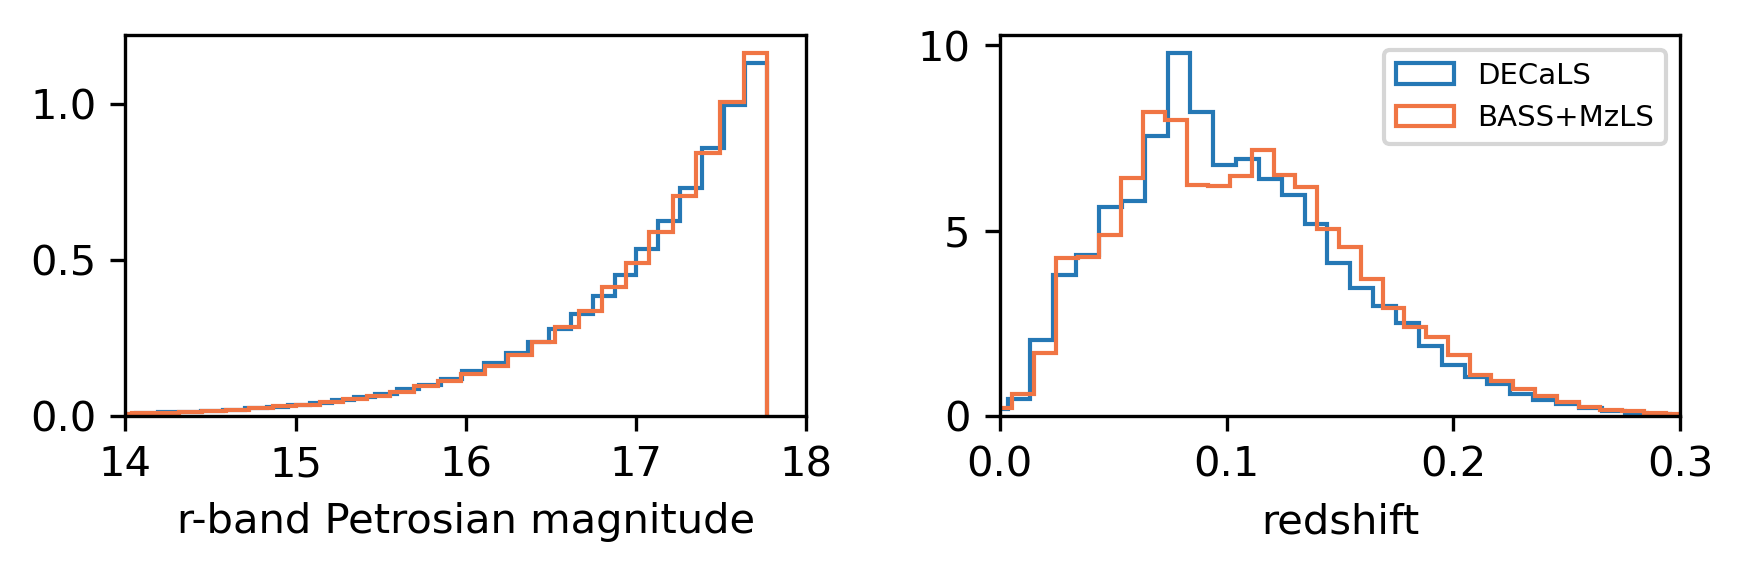

In [25]:
plt.figure(figsize=(6, 2), dpi=300)
plt.subplot(1, 2, 1)
plt.hist(in_decals.petro_mag, bins=50, histtype='step', label="DECaLS", alpha=1, stacked=True, color="#2578b5",density=True)
plt.hist(out_decals.petro_mag, bins=50, histtype='step', label="BASS+MzLS", alpha=1, stacked=True, color="#f07544",density=True)
plt.xlabel("r-band Petrosian magnitude")
plt.xlim((14, 18))
plt.subplot(1, 2, 2)
plt.hist(in_decals.z, bins=50, histtype='step', label="DECaLS", alpha=1, stacked=True, color="#2578b5",density=True)
plt.hist(out_decals.z, bins=50, histtype='step', label="BASS+MzLS", alpha=1, stacked=True, color="#f07544",density=True)
plt.legend(fontsize=7)
plt.xlim((0, 0.3))
plt.tight_layout()
plt.xlabel("redshift")
plt.show()

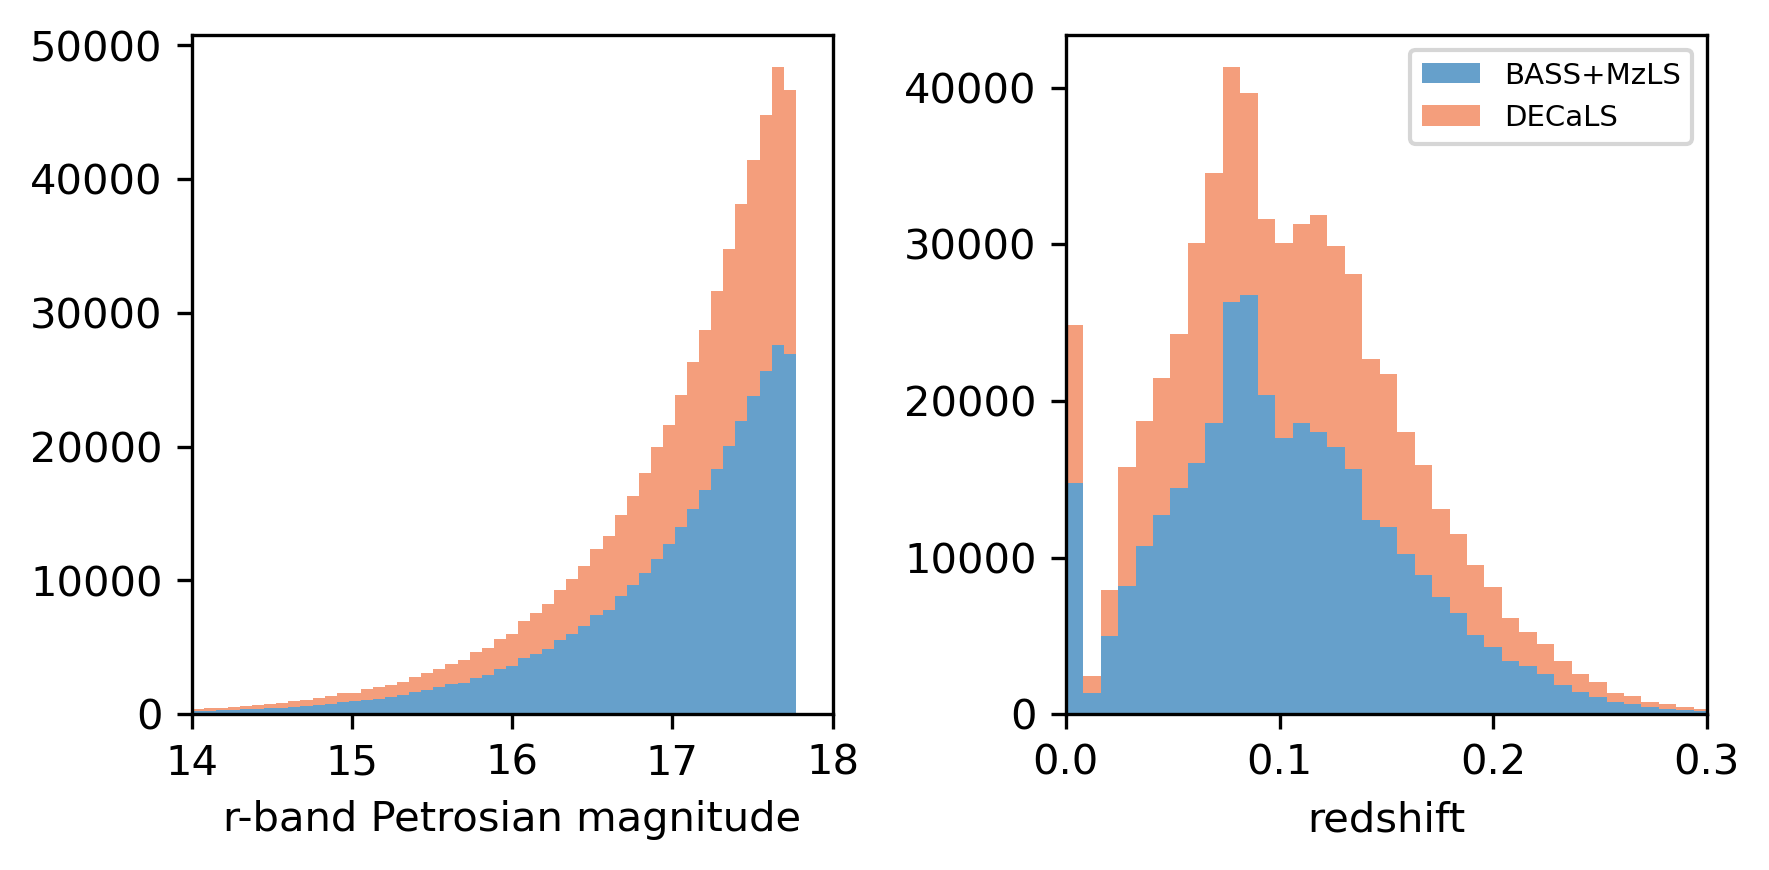

In [16]:
plt.figure(figsize=(6, 3), dpi=300)
plt.subplot(1, 2, 1)
plt.hist([mgs_in_decals.petro_mag, mgs_out_decals.petro_mag], bins=50, histtype='bar', label=["BASS+MzLS", "DECaLS"], alpha=0.7, stacked=True, color=["#2578b5", "#f07544"])
plt.xlabel("r-band Petrosian magnitude")
plt.xlim((14, 18))
plt.subplot(1, 2, 2)
plt.hist([mgs_in_decals.z, mgs_out_decals.z], bins=800, histtype='bar', label=["BASS+MzLS", "DECaLS"], color=["#2578b5", "#f07544"], alpha=0.7, stacked=True)
plt.legend(fontsize=7)
plt.xlim((0, 0.3))
plt.tight_layout()
plt.xlabel("redshift")
plt.show()

In [39]:
def get_each_question(df_c, votes):
    return df_c.query("smooth_or_featured_total_votes >= %d" % votes),\
           df_c.query("disk_edge_on_total_votes >= %d" % votes),\
           df_c.query("has_spiral_arms_total_votes >= %d" % votes),\
           df_c.query("bar_total_votes >= %d" % votes),\
           df_c.query("bulge_size_total_votes >= %d" % votes),\
           df_c.query("how_rounded_total_votes >= %d" % votes),\
           df_c.query("edge_on_bulge_total_votes >= %d" % votes),\
           df_c.query("spiral_winding_total_votes >= %d" % votes),\
           df_c.query("spiral_arm_count_total_votes >= %d" % votes),\
           df_c.query("merging_total_votes >= %d" % votes)
def get_total_question(df, votes, operator):
    if operator == ">=":
        # return df.query("smooth_or_featured_total_votes >= %d | disk_edge_on_total_votes >= %d | has_spiral_arms_total_votes >= %d | bar_total_votes >= %d | bulge_size_total_votes >= %d | how_rounded_total_votes >= %d | edge_on_bulge_total_votes >= %d | spiral_winding_total_votes >= %d | spiral_arm_count_total_votes >= %d | merging_total_votes >= %d" %(votes, votes, votes, votes, votes, votes, votes, votes, votes, votes))
        return df.query("smooth_or_featured_total_votes >= %d" %(votes))
    if operator == "<=":
        return df.query("smooth_or_featured_total_votes >= 3 | disk_edge_on_total_votes >= 3 | has_spiral_arms_total_votes >= 3 | bar_total_votes >= 3 | bulge_size_total_votes >= 3 | how_rounded_total_votes >= 3 | edge_on_bulge_total_votes >= 3 | spiral_winding_total_votes >= 3 | spiral_arm_count_total_votes >= 3 | merging_total_votes >= 3").query("smooth_or_featured_total_votes <= %d | disk_edge_on_total_votes <= %d | has_spiral_arms_total_votes <= %d | bar_total_votes <= %d | bulge_size_total_votes <= %d | how_rounded_total_votes <= %d | edge_on_bulge_total_votes <= %d | spiral_winding_total_votes <= %d | spiral_arm_count_total_votes <= %d | merging_total_votes <= %d" %(votes, votes, votes, votes, votes, votes, votes, votes, votes, votes))

In [25]:
# in_decals = match(mgs_in_decals, df_c, 2, ["real_ra", "real_dec"]).drop(columns=["ra", "dec"]).rename(columns={"real_ra":"ra", "real_dec":"dec"})
# out_decals = match(mgs_out_decals, df_c, 2, ["real_ra", "real_dec"]).drop(columns=["ra", "dec"]).rename(columns={"real_ra":"ra", "real_dec":"dec"})
# overlap = match(in_decals[["ra", "dec"]], out_decals, 2, ["in_ra", "in_dec"]).drop(columns=["ra", "dec"]).rename(columns={"in_ra":"ra", "in_dec":"dec"})
only_in_decals = pd.concat([in_decals, out_decals, out_decals]).drop_duplicates(keep=False)
only_out_decals = pd.concat([out_decals, in_decals, in_decals]).drop_duplicates(keep=False)
len(in_decals), len(out_decals), len(overlap), len(only_in_decals), len(only_out_decals)

(409270, 227466, 375377, 381599, 199795)

In [31]:
only_in_decals_labels = match(labels, only_in_decals, 2, ["in_ra", "in_dec"]).drop(columns=["ra", "dec"]).rename(columns={"in_ra":"ra", "in_dec":"dec"})

In [33]:
def count_rows_with_votes_over_34(df,votes):
    columns = ["smooth_or_featured_total_votes", "disk_edge_on_total_votes",
               "has_spiral_arms_total_votes", "bar_total_votes",
               "bulge_size_total_votes", "how_rounded_total_votes",
               "edge_on_bulge_total_votes", "spiral_winding_total_votes",
               "spiral_arm_count_total_votes", "merging_total_votes"]
    result = {}
    for column in columns:
        result[column] = df[df[column] >= votes].shape[0]
    return result

In [34]:
count_rows_with_votes_over_34(only_in_decals_labels,3)

{'smooth_or_featured_total_votes': 174968,
 'disk_edge_on_total_votes': 84089,
 'has_spiral_arms_total_votes': 68801,
 'bar_total_votes': 68801,
 'bulge_size_total_votes': 68801,
 'how_rounded_total_votes': 127819,
 'edge_on_bulge_total_votes': 19981,
 'spiral_winding_total_votes': 39698,
 'spiral_arm_count_total_votes': 39698,
 'merging_total_votes': 172412}

In [57]:
only_in_decals_data = get_total_question(only_in_decals_labels, 3, ">=")
len(only_in_decals_data), len(overlap)/len(only_in_decals_data)

(174968, 0.02789081432033286)

In [44]:
overlap_labels = match(labels, overlap, 2, ["in_ra", "in_dec"]).drop(columns=["ra", "dec"]).rename(columns={"in_ra":"ra", "in_dec":"dec"})

In [45]:
len(overlap)

375377

In [59]:
train, valid = train_test_split(only_in_decals_data, train_size=0.82, random_state=1926)
valid = pd.concat([valid, overlap_labels])
len(train), len(valid), len(train)/(len(valid)+len(train))

(143473, 36375, 0.7977458742938481)

In [51]:
question_answer_pairs = gz2_pairs
dependencies = gz2_and_decals_dependencies
schema = Schema(question_answer_pairs, dependencies)
label_cols = schema.label_cols
def get_galaxy_label(galaxy, label_cols):
    return galaxy[label_cols].infer_objects().values.squeeze()  # squeeze for if there's one label_col

In [60]:
func = ["train", "valid"]
dataset = [train, valid]
for i in range(len(func)):
    with open("/data/public/renhaoye/mgs/%s_1009.txt" % func[i] , "w") as w:
        for j in range(len(dataset[i])):
            ra, dec = str(dataset[i].iloc[j, 0]), str(dataset[i].iloc[j, 1]),
            path = "/data1/public/BGS/bgs_bright_south/" + ra + "_" + dec + ".fits"
            if os.path.exists(path):
                w.write(path + " label:")
                for v in get_galaxy_label(dataset[i].iloc[j], label_cols):
                    w.write(str(v) + " ")
                w.write(" \n")
            elif os.path.exists(f"/data1/public/BGS/bgs_bright_south_overlap/{ra}_{dec}.fits"):
                w.write(f"/data1/public/BGS/bgs_bright_south_overlap/{ra}_{dec}.fits" + " label:")
                for v in get_galaxy_label(dataset[i].iloc[j], label_cols):
                    w.write(str(v) + " ")
                w.write(" \n")
            else:
                print(path.split(".fits")[0])

In [16]:
out_path = "/data/public/renhaoye/morphics/dataset/in_decals/raw_fits/"
with open("/data/public/renhaoye/morphics/dataset/overlap_south_raw.txt", "w") as w:
    for j in range(len(overlap)):
        ra, dec = str(overlap.iloc[j, 0]), str(overlap.iloc[j, 1]),   # 先拿坐标和标签，这一步仅适用于decals的，sdss匹配的不可以
        path = out_path + ra + "_" + dec + ".fits"
        if os.path.exists(path):
            w.write(path + " label:")
            for v in get_galaxy_label(overlap.iloc[j], label_cols):
                w.write(str(v) + " ")
            w.write(" \n")
        else:
            print(path.split(".fits")[0])

In [17]:
out_path = "/data/public/renhaoye/morphics/dataset/out_decals/raw_fits/"
with open("/data/public/renhaoye/morphics/dataset/overlap_north_raw.txt", "w") as w:
    for j in range(len(overlap)):
        ra, dec = str(overlap.iloc[j, 0]), str(overlap.iloc[j, 1]),   # 先拿坐标和标签，这一步仅适用于decals的，sdss匹配的不可以
        path = out_path + ra + "_" + dec + ".fits"
        if os.path.exists(path):
            w.write(path + " label:")
            for v in get_galaxy_label(overlap.iloc[j], label_cols):
                w.write(str(v) + " ")
            w.write(" \n")
        else:
            print(path.split(".fits")[0])

In [12]:
out_path = pkg + "/data/out_decals/stretched/"
with open(pkg + "data/overlap_north.txt", "w") as w:
    for j in range(len(overlap)):
        ra, dec = str(overlap.iloc[j, 0]), str(overlap.iloc[j, 1]),   # 先拿坐标和标签，这一步仅适用于decals的，sdss匹配的不可以
        path = out_path + ra + "_" + dec + ".fits"
        if os.path.exists(path):
            w.write(path + " label:")
            for v in get_galaxy_label(overlap.iloc[j], label_cols):
                w.write(str(v) + " ")
            w.write(" \n")
        else:
            print(path.split(".fits")[0])

In [13]:
out_path = pkg + "/data/in_decals/stretched/"
with open(pkg + "data/overlap_south.txt", "w") as w:
    for j in range(len(overlap)):
        ra, dec = str(overlap.iloc[j, 0]), str(overlap.iloc[j, 1]),   # 先拿坐标和标签，这一步仅适用于decals的，sdss匹配的不可以
        path = out_path + ra + "_" + dec + ".fits"
        if os.path.exists(path):
            w.write(path + " label:")
            for v in get_galaxy_label(overlap.iloc[j], label_cols):
                w.write(str(v) + " ")
            w.write(" \n")
        else:
            print(path.split(".fits")[0])

In [12]:
train_uda, valid_uda = train_test_split(df_out_decals, train_size=0.9, random_state=1926)

In [29]:
out_path = pkg + "/data/out_decals/stretched/"
with open(pkg + "/data/train_uda.txt", "w") as w:
    for i in range(len(train_uda)):
        ra = train_uda.iloc[i, 0]
        dec = train_uda.iloc[i, 1]
        if os.path.exists(out_path + str(ra) +"_"+str(dec)+".fits"):
            w.writelines(out_path + str(ra) +"_"+str(dec)+".fits\n")

In [30]:
out_path = pkg + "/data/out_decals/stretched/"
with open(pkg + "/data/valid_uda.txt", "w") as w:
    for i in range(len(valid_uda)):
        ra = valid_uda.iloc[i, 0]
        dec = valid_uda.iloc[i, 1]
        if os.path.exists(out_path + str(ra) +"_"+str(dec)+".fits"):
            w.writelines(out_path + str(ra) +"_"+str(dec)+".fits\n")

In [31]:
out_path = pkg + "/data/out_decals/stretched/"
with open(pkg + "/data/mgs_out_decals.txt", "w") as w:
    for i in range(len(mgs_out_decals)):
        ra = mgs_out_decals.iloc[i, 0]
        dec = mgs_out_decals.iloc[i, 1]
        if os.path.exists(out_path + str(ra) + "_" + str(dec) + ".fits"):
            w.writelines(out_path + str(ra) + "_" + str(dec) + ".fits\n")

In [21]:
out_path = "/data/public/renhaoye/morphics/dataset/out_decals/raw_fits/"
with open(pkg + "/data/train_uda_raw.txt", "w") as w:
    for i in range(len(train_uda)):
        ra = train_uda.iloc[i, 0]
        dec = train_uda.iloc[i, 1]
        if os.path.exists(out_path + str(ra) +"_"+str(dec)+".fits"):
            w.writelines(out_path + str(ra) +"_"+str(dec)+".fits\n")

In [22]:
out_path = "/data/public/renhaoye/morphics/dataset/out_decals/raw_fits/"
with open(pkg + "/data/valid_uda_raw.txt", "w") as w:
    for i in range(len(valid_uda)):
        ra = valid_uda.iloc[i, 0]
        dec = valid_uda.iloc[i, 1]
        if os.path.exists(out_path + str(ra) +"_"+str(dec)+".fits"):
            w.writelines(out_path + str(ra) +"_"+str(dec)+".fits\n")

In [8]:
out_path = "/data/public/renhaoye/morphics/dataset/in_decals/raw_fits/"
with open(pkg + "/data/south_raw.txt", "w") as w:
    for i in range(len(in_decals)):
        ra = in_decals.iloc[i, 0]
        dec = in_decals.iloc[i, 1]
        if os.path.exists(out_path + str(ra) +"_"+str(dec)+".fits"):
            w.writelines(out_path + str(ra) +"_"+str(dec)+".fits\n")

In [31]:
out_path = pkg + "/data/out_decals/stretched/"
with open(pkg + "/data/mgs_out_decals.txt", "w") as w:
    for i in range(len(mgs_out_decals)):
        ra = mgs_out_decals.iloc[i, 0]
        dec = mgs_out_decals.iloc[i, 1]
        if os.path.exists(out_path + str(ra) + "_" + str(dec) + ".fits"):
            w.writelines(out_path + str(ra) + "_" + str(dec) + ".fits\n")

In [14]:
out_path = "/data/public/renhaoye/morphics/dataset/in_decals/raw_fits/"
with open(pkg + "/data/south_raw.txt", "w") as w:
    for i in range(len(mgs_in_decals)):
        ra = mgs_in_decals.iloc[i, 0]
        dec = mgs_in_decals.iloc[i, 1]
        if os.path.exists(out_path + str(ra) +"_"+str(dec)+".fits"):
            w.writelines(out_path + str(ra) +"_"+str(dec)+".fits\n")

In [15]:
out_path = "/data/public/renhaoye/morphics/dataset/out_decals/raw_fits/"
with open(pkg + "/data/north_raw.txt", "w") as w:
    for i in range(len(mgs_out_decals)):
        ra = mgs_out_decals.iloc[i, 0]
        dec = mgs_out_decals.iloc[i, 1]
        if os.path.exists(out_path + str(ra) +"_"+str(dec)+".fits"):
            w.writelines(out_path + str(ra) +"_"+str(dec)+".fits\n")